In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [13]:
# Load pre-trained model weights
base_model = load_model('/home/apando/models/tomnod_everything_relu_Adam.h5')

In [14]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
__________

In [4]:
# Run the model as-is on a subset of Hurricane Maria dataset
maria_dir = '/home/apando/datasets/building_crops_small/test'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                    maria_dir, 
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')
test_results = base_model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
test_results

Found 220 images belonging to 2 classes.
11/11 [==============================] - 14s 1s/step


[1.364331234585155, 0.5318181866949255]

In [6]:
# F1 score on Maria small/clean test dataset, model as-is.
from sklearn import metrics

maria_test_dir = '/home/apando/datasets/building_crops_small/test'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                    maria_test_dir, 
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary', shuffle=False)

predictions = base_model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

val_targ = []
for i in range(0,len(test_generator)):
    val_targ.extend(np.array(test_generator[i][1]))

val_predict = (np.asarray(predictions)).round().flatten()

print(val_targ[100:200])
print(val_predict[100:200])

val_f1 = metrics.f1_score(val_targ, val_predict)
val_recall = metrics.recall_score(val_targ, val_predict)
val_precision = metrics.precision_score(val_targ, val_predict)
val_acc = metrics.accuracy_score(val_targ, val_predict)

print("F1: {0}, Recall: {1}, Precision: {2}, Accuracy: {3}".format(val_f1, val_recall, val_precision, val_acc))

Found 220 images belonging to 2 classes.
11/11 [==============================] - 0s 31ms/step
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0.]
F1: 0.45502645502645506, Recall: 0.39814814814814814, Precision: 0.5308641975308642, Accuracy: 0.5

In [11]:
# Set input paths to small, clean dataset
import os 

train_dir = '/home/apando/datasets/building_crops_small/train/'
validation_dir = '/home/apando/datasets/building_crops_small/validate/'
test_dir = '/home/apando/datasets/building_crops_small/test/'

train_size = validation_size = test_size = 0
for l in ('damaged', 'non_damaged'):
    train_size += len(os.listdir(train_dir + l))
    validation_size += len(os.listdir(validation_dir + l))
    test_size += len(os.listdir(test_dir + l))
    
print("Train:{} Valdiate:{} Test:{}".format(train_size, validation_size, test_size))

Train:2567 Valdiate:208 Test:224


In [14]:
# Freeze convolutional base into a new model, excluding flattened/dense layers
fr_base_model = models.Sequential()
for layer in base_model.layers[:-4]:
    fr_base_model.add(layer)
    
fr_base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
__________

In [15]:
# Transfer learning on frozen convolutional base

# Extract features from base
import shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32
img_width = img_height = 150

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 128))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through frozen base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = fr_base_model.predict(inputs_batch)
        try:
            features[i * batch_size: (i + 1) * batch_size] = features_batch
            labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        except:
            print(features_batch.shape)
            print(labels_batch.shape)
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels


print("Processing train")
train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size
print("Processing validation")
validation_features, validation_labels = extract_features(validation_dir, validation_size)
print("Processing test")
test_features, test_labels = extract_features(test_dir, test_size)


Processing train
Found 2563 images belonging to 2 classes.
(3, 7, 7, 128)
(3,)
Processing validation
Found 204 images belonging to 2 classes.
(12, 7, 7, 128)
(12,)
Processing test
Found 220 images belonging to 2 classes.
(28, 7, 7, 128)
(28,)


In [43]:
# New top
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

frozen_base_model = models.Sequential()
frozen_base_model.add(layers.Flatten(input_shape=(7,7,128)))
frozen_base_model.add(layers.Dropout(0.5))
frozen_base_model.add(layers.Dense(512,activation='relu', input_dim=(7*7*512)))
frozen_base_model.add(layers.Dense(1, activation='sigmoid'))
frozen_base_model.summary()

# Compile model
frozen_base_model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])
              
# Train model
history = frozen_base_model.fit(
        train_features, 
        train_labels,
        epochs=epochs,
        steps_per_epoch=100,
        batch_size=batch_size, 
        validation_data=(validation_features, validation_labels),
        validation_steps=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 6272)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               3211776   
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 513       
Total params: 3,212,289
Trainable params: 3,212,289
Non-trainable params: 0
_________________________________________________________________
Train on 2567 samples, validate on 208 samples
Epoch 1/100
100/100 [==============================] - 10s 100ms/step - loss: 0.4593 - acc: 0.7629 - val_loss: 0.8011 - val_acc: 0.5096
Epoch 2/100
100/100 [==============================] - 9s 93ms/step - loss: 0.237

In [46]:
frozen_base_model.save('/home/apando/models/tomnod_everything_relu_Adam-frozen_base.h5')

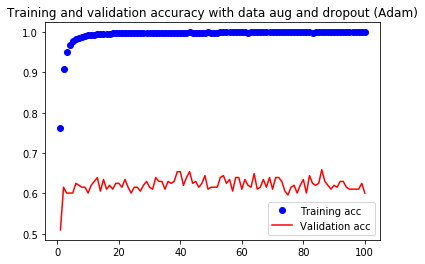

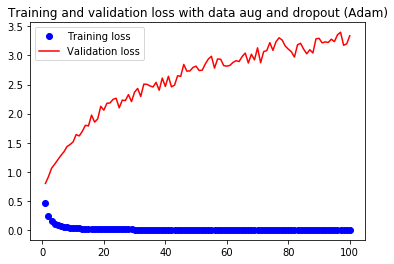

In [47]:
# Plot loss and accuracy
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy with dropout (Adam)')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss with dropout (Adam)')
plt.legend()

plt.show()

In [48]:
# Dropout after dense layer + reduce # of steps
# Halted after 41 epochs; definitely overfitting. Dataset is too small.

from keras import models
from keras import layers
from keras import optimizers

epochs = 100

frozen_base_model = models.Sequential()
frozen_base_model.add(layers.Flatten(input_shape=(7,7,128)))
frozen_base_model.add(layers.Dense(512,activation='relu', input_dim=(7*7*128)))
frozen_base_model.add(layers.Dropout(0.5))
frozen_base_model.add(layers.Dense(1, activation='sigmoid'))
frozen_base_model.summary()

# Compile model
frozen_base_model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])
              
# Train model
history = frozen_base_model.fit(
        train_features, 
        train_labels,
        epochs=epochs,
        steps_per_epoch=50,
        #batch_size=batch_size, 
        validation_data=(validation_features, validation_labels),
        validation_steps=25)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               3211776   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 513       
Total params: 3,212,289
Trainable params: 3,212,289
Non-trainable params: 0
_________________________________________________________________
Train on 2567 samples, validate on 208 samples
Epoch 1/100
50/50 [==============================] - 5s 104ms/step - loss: 0.5118 - acc: 0.7323 - val_loss: 0.7340 - val_acc: 0.5577
Epoch 2/100
50/50 [==============================] - 4s 89ms/step - loss: 0.2955 - a

KeyboardInterrupt: 

In [49]:
# Try out global average pooling
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

frozen_base_model = models.Sequential()
frozen_base_model.add(layers.GlobalAveragePooling2D(input_shape=(7,7,128)))
frozen_base_model.add(layers.Dense(1, activation='sigmoid'))
frozen_base_model.summary()

# Compile model
frozen_base_model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])
              
# Train model
history = frozen_base_model.fit(
    train_features, 
    train_labels,
    epochs=epochs,
    steps_per_epoch=50,
    #batch_size=batch_size, 
    validation_data=(validation_features, validation_labels),
    validation_steps=25)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________
Train on 2567 samples, validate on 208 samples
Epoch 1/100
50/50 [==============================] - 4s 73ms/step - loss: 0.6899 - acc: 0.5698 - val_loss: 0.6880 - val_acc: 0.5577
Epoch 2/100
50/50 [==============================] - 3s 62ms/step - loss: 0.6857 - acc: 0.5756 - val_loss: 0.6853 - val_acc: 0.5721
Epoch 3/100
50/50 [==============================] - 3s 65ms/step - loss: 0.6826 - acc: 0.5737 - val_loss: 0.6835 - val_acc: 0.5721
Epoch 4/100
50/50 [==============================] - 3s 64ms/step - loss: 0.6805 - acc: 0.5748 - 

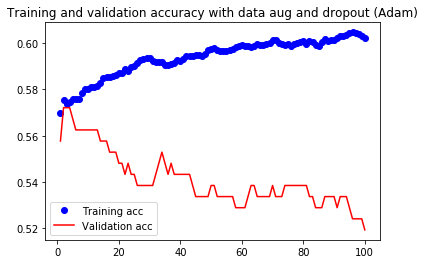

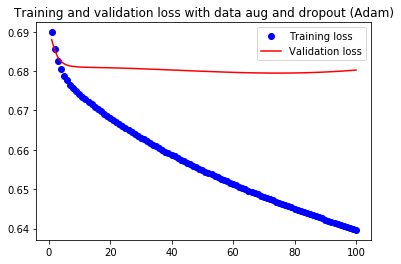

In [50]:
# Plot loss and accuracy
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy with data aug and dropout (Adam)')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss with data aug and dropout (Adam)')
plt.legend()

plt.show()

In [23]:
# Create new model, including new top from 1st scheme. Freeze original base model layers.
new_top_model = models.Sequential()
for layer in base_model.layers[:-4]:
    new_top_model.add(layer)
for layer in new_top_model.layers:
    layer.trainable = False

new_top_model.add(layers.Flatten(input_shape=(7,7,128)))
new_top_model.add(layers.Dropout(0.5))
new_top_model.add(layers.Dense(512,activation='relu', input_dim=(7*7*512)))
new_top_model.add(layers.Dense(1, activation='sigmoid'))
new_top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
__________

In [20]:
base_model = load_model('/home/apando/models/tomnod_everything_relu_Adam.h5')

# New model, re-initialize top. Freeze all original base model layers.
new_top_model = models.Sequential()
for layer in base_model.layers[:-4]:
    new_top_model.add(layer)
for layer in new_top_model.layers:
    layer.trainable = False

new_top_model.add(layers.Flatten(input_shape=(7,7,128)))
new_top_model.add(layers.Dropout(0.5))
new_top_model.add(layers.Dense(512,activation='relu', input_dim=(7*7*512)))
new_top_model.add(layers.Dense(1, activation='sigmoid'))
new_top_model.summary()

# Train with data augmentation, on small clean dataset.
train_dir = '/home/apando/datasets/building_crops_small/train/'
validation_dir = '/home/apando/datasets/building_crops_small/validate/'
test_dir = '/home/apando/datasets/building_crops_small/test/'

from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_dir, 
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')
validation_generator = validation_datagen.flow_from_directory(
                    validation_dir,
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')

# Compile model
new_top_model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])
              
# Train generator
history = new_top_model.fit_generator(
            train_generator,
            steps_per_epoch=100,
            epochs=100,
            validation_data=validation_generator,
            validation_steps=50,
            shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
__________

In [21]:
new_top_model.save('/home/apando/models/tomnod_everything_relu_Adam-frozen_base_data_aug.h5')

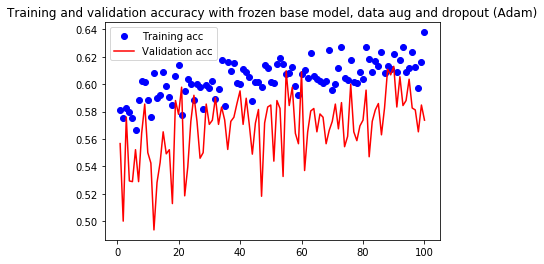

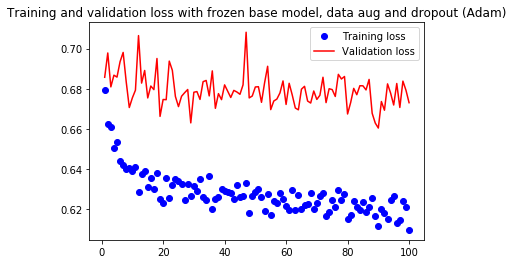

In [22]:
# Plot loss and accuracy
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy with frozen base model, data aug and dropout (Adam)')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss with frozen base model, data aug and dropout (Adam)')
plt.legend()

plt.show()

In [28]:
# Sanity check: try new scheme (only training top) without data augmentation.
# Accuracy is lower than using convolutional base output as input for the top and only training the top. 
# Less overfitting though!

# Freeze original base model layers. Add new top.
new_top_model = models.Sequential()
for layer in base_model.layers[:-4]:
    new_top_model.add(layer)
for layer in new_top_model.layers:
    layer.trainable = False

new_top_model.add(layers.Flatten(input_shape=(7,7,128)))
new_top_model.add(layers.Dropout(0.5))
new_top_model.add(layers.Dense(512,activation='relu', input_dim=(7*7*512)))
new_top_model.add(layers.Dense(1, activation='sigmoid'))
new_top_model.summary()

# No data augmentation, on small clean dataset.
from keras.preprocessing.image import ImageDataGenerator

train_dir = '/home/apando/datasets/building_crops_small/train/'
validation_dir = '/home/apando/datasets/building_crops_small/validate/'
test_dir = '/home/apando/datasets/building_crops_small/test/'

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_dir, 
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')
validation_generator = validation_datagen.flow_from_directory(
                    validation_dir,
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')

# Compile model
new_top_model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])
              
# Train generator
history = new_top_model.fit_generator(
            train_generator,
            steps_per_epoch=100,
            epochs=100,
            validation_data=validation_generator,
            validation_steps=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
__________

In [23]:
# Train top with data augmentation, on small clean dataset, keeping all pre-trained weights.

from keras import models
from keras import layers
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator

base_model = load_model('/home/apando/models/tomnod_everything_relu_Adam.h5')

# Keep base model, freeze convolutional base
pretrained_top_model = models.Sequential()
for layer in base_model.layers:
    pretrained_top_model.add(layer)
for layer in pretrained_top_model.layers[:-4]:
    layer.trainable = False

pretrained_top_model.summary()

# Re-train trainable parameters (FC/Dense layers)
train_dir = '/home/apando/datasets/building_crops_small/train/'
validation_dir = '/home/apando/datasets/building_crops_small/validate/'
test_dir = '/home/apando/datasets/building_crops_small/test/'

train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_dir, 
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')
validation_generator = validation_datagen.flow_from_directory(
                    validation_dir,
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')

# Compile model
pretrained_top_model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])
              
# Train generator
history = pretrained_top_model.fit_generator(
            train_generator,
            steps_per_epoch=100,
            epochs=100,
            validation_data=validation_generator,
            validation_steps=50,
            shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
__________

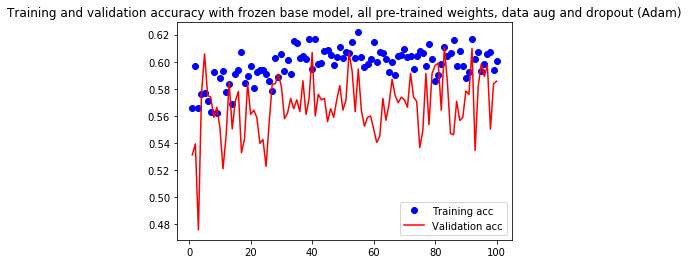

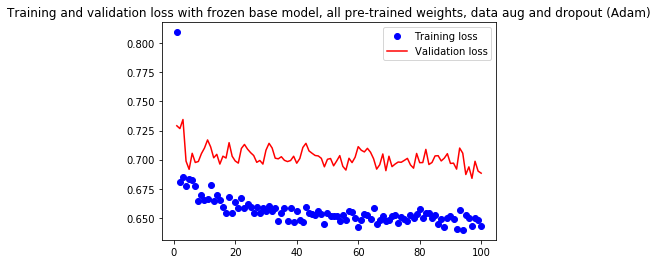

In [24]:
# Plot loss and accuracy
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy with frozen base model, all pre-trained weights, data aug and dropout (Adam)')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss with frozen base model, all pre-trained weights, data aug and dropout (Adam)')
plt.legend()

plt.show()

In [ ]:
# Freeze original base model layers. Re-initialize top. Smaller learn rate, more epochs.

base_model = load_model('/home/apando/models/tomnod_everything_relu_Adam.h5')

# New model, re-initialize top. Freeze all original base model layers.
nt_lr_model = models.Sequential()
for layer in base_model.layers[:-4]:
    nt_lr_model.add(layer)
for layer in nt_lr_model.layers:
    layer.trainable = False
    
nt_lr_model.summary()

nt_lr_model.add(layers.Flatten(input_shape=(7,7,128), name='flatten_top'))
nt_lr_model.add(layers.Dropout(0.5, name='flatten_dropout'))
nt_lr_model.add(layers.Dense(512,activation='relu', input_dim=(7*7*512), name='dense_top'))
nt_lr_model.add(layers.Dense(1, activation='sigmoid', name='dense_top_2'))
nt_lr_model.summary()

# Train with data augmentation, on small clean dataset.
train_dir = '/home/apando/datasets/building_crops_small/train/'
validation_dir = '/home/apando/datasets/building_crops_small/validate/'
test_dir = '/home/apando/datasets/building_crops_small/test/'

from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_dir, 
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')
validation_generator = validation_datagen.flow_from_directory(
                    validation_dir,
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')

# Compile model
nt_lr_model.compile(optimizer=optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])
              
# Train generator
history = nt_lr_model.fit_generator(
            train_generator,
            steps_per_epoch=100,
            epochs=200,
            validation_data=validation_generator,
            validation_steps=50,
            shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
__________